### Group members: 
Thor Noe 
Christian Lund Sørensen
Morten Esketveit Rasmussen

# Assignment 3


### Practical info
* Handin in absalon. The deadline is the 23rd of April (see the [course plan](https://github.com/abjer/tsds/wiki/Course-plan))
* You must work in groups of 2-4. **Remember to identify the group members in the filename or in the top of the file contents**.
* If anything is unclear dont hesitate to email me at kuol@econ.ku.dk with questions.

<br>

<br>
<br>
<br>
<br>

# Questions from exercise set 9 (Spatial #1)


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)

In [3]:
kommuner = kommuner.to_crs({'init':'epsg:25832'})

kommuner.columns = kommuner.columns.str.lower()


In [4]:
# Run this code to get set up for exercise 9.2.2 - 9.2.5

    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')


dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}
def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [76]:
kommuner.head(3)

,komkode,komnavn,geometry,regionskode,regionsnavn,boolean1,boolean2,boolean3
0,0766,Hedensted,"POLYGON Z ((528116 6190640.999997549 -999, 528...",1082,Region Midtjylland,False,True,False
1,0766,Hedensted,"POLYGON Z ((566517 6188004.429997538 -999, 566...",1082,Region Midtjylland,False,True,False
2,0561,Esbjerg,"POLYGON Z ((474537 6154408.999997615 -999, 474...",1083,Region Syddanmark,False,True,False


**Ex. 9.2.2** Make two boolean series as follows. 
 - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
 - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

Finally make a combined series which takes the value True if both holds, otherwise False and use this series to select rows in the GeoDataFrame. 

> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [77]:
kommuner["boolean1"] = ((kommuner["regionsnavn"] == "Region Hovedstaden") | (kommuner["regionsnavn"] == "Region Sjælland"))
kommuner["boolean2"] = np.logical_not(kommuner["komnavn"].isin(["Bornholm","Christiansø"]))
kommuner["boolean3"] = kommuner.boolean1 & kommuner.boolean2
print(kommuner["boolean1"].value_counts(), '\n', 
      kommuner["boolean2"].value_counts(), '\n',
      kommuner["boolean3"].value_counts())
sealand = kommuner.loc[kommuner.boolean3 == True]
sealand.head(3)

False    191
True     120
Name: boolean1, dtype: int64 
 True     307
False      4
Name: boolean2, dtype: int64 
 False    195
True     116
Name: boolean3, dtype: int64


,komkode,komnavn,geometry,regionskode,regionsnavn,boolean1,boolean2,boolean3
12,0159,Gladsaxe,POLYGON Z ((716688.9999987364 6181564.99997987...,1084,Region Hovedstaden,True,True,True
16,0260,Halsnæs,POLYGON Z ((685760.6499997635 6206386.18999028...,1084,Region Hovedstaden,True,True,True
17,0260,Halsnæs,POLYGON Z ((667292.9999999347 6231337.99999349...,1084,Region Hovedstaden,True,True,True


**Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

>***Answer to ex. 9.2.3:***
>
> The CRS is ETRS89. Coordinates are in meters, making it easy to measure distance between to points using the pythagorean theorem. (right?) 
>
> Supposedly, there will be some error due to curvature?


In [71]:
maxx = sealand.bounds.maxx.max()
maxy = sealand.bounds.maxy.max()
minx = sealand.bounds.minx.min()
miny = sealand.bounds.miny.min()

In [72]:
print(minx, maxx, miny, maxy)

617288.0000000043 739259.9999965408 6049781.999990508 6231607.999993474


#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

**Ex. 9.2.4** We are now to construct a 500mx500m grid for Sealand:
- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. 
- For each of these points construct a square polygon assuming that the point is the south west corner of the square. 
- Select all the house sales that take place within the Sealand and nearby islands.

> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.

> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [73]:
# Create points in grid
# KOMMENTAR: Foreløbig lidt en banal måde at gøre det på - ret meget gerne.
x_points = [0]*int(round((maxx-minx)/500))
xn_points = int(round((maxx-minx)/500))
for i in range(xn_points) : 
    x_points[i] = minx + i*500


y_points = [0]*int(round((maxy-miny)/500))
yn_points = int(round((maxy-miny)/500))
for i in range(yn_points) : 
    y_points[i] = miny + i*500
    

## Combine to get grid
grid = [(x,y) for x in x_points for y in y_points]

In [78]:
# Create DataFrame from (x,y) coordinates, and name columns appropriately 
points_df = pd.DataFrame(grid)
points_df.columns = ["x_points", "y_points"]
# Use pre-defined function to create GeoDataFrame with grid cells as geometry. 
squares_df = cell_coords_to_polygons(points_df, x='x_points', y='y_points')
squares_df.head(3)

,x_points,y_points,geometry
0,617288.0,6.049782e+06,"POLYGON ((617288.0000000043 6049781.999990508,..."
1,617288.0,6.050282e+06,"POLYGON ((617288.0000000043 6050281.999990508,..."
2,617288.0,6.050782e+06,"POLYGON ((617288.0000000043 6050781.999990508,..."


**Ex. 9.2.5** Compute interpolation of house price for each grid cell as follows:
- Load the pre-structured data with house sales prices for the capital region of Denmark
- Make a loop over sale_year
    - Fit a nearest neighbor regression model to the square meter price (i.e. `price_area` for each year)
        - Set number of neighbors to 25 and radius to 25000
    - Apply the model to the grid data and assign as a column
- Plot the grid data for 2012

In [92]:
# Load data
house_sales = gpd.read_file("house_prices.geojson")
house_sales['n'] = house_sales.geometry.y
house_sales['e'] = house_sales.geometry.x
print(house_sales.crs)
house_sales.head(3)

{'init': 'epsg:4326'}


,id,address,buildYear,salesPeriodTotal,numberOfRooms,paymentCash,residentialArea,areaWeighted,postal,dateRemoved,city,lat,lon,price_area,price_area_log,sale_year,geometry,n,e
0,0,"Topperne 11, 1. 12",1972,NaN,2,645000.0,49.0,49.0,2620,19-01-2012,Albertslund,55.672423,12.343027,13163.265306,9.485185,2012,POINT (710214.0005973534 6174689.003205985),6.174689e+06,710214.000597
1,1,"Topperne 11, 1. 12",1972,NaN,2,575000.0,49.0,49.0,2620,19-07-2012,Albertslund,55.672423,12.343027,11734.693878,9.370305,2012,POINT (710214.0005973534 6174689.003205985),6.174689e+06,710214.000597
2,2,Skyttehusene 37,1968,NaN,4,1695000.0,108.0,131.0,2620,12-03-2012,Albertslund,55.672528,12.356639,12938.931298,9.467996,2012,POINT (711069.0006191777 6174742.003206357),6.174742e+06,711069.000619


In [93]:
knr = KNeighborsRegressor(n_neighbors=25, radius=25000)

for y in house_sales['sale_year'].unique():
    # Take out price data for one year
    price_coord = house_sales[(house_sales.sale_year==y)].dropna(subset=['sale_year', 'e', 'n', 'price_area'])

    # Estimate knr model
    price_nn = knr.fit(X=price_coord[['e', 'n']].values,
                       y=price_coord.price_area.values)

    # Predict on square grid
    squares_df['s' + str(y)] = np.log10(price_nn.predict(squares_df[['x_points', 'y_points']] + 250))

squares_df.head(3)

,x_points,y_points,geometry,s2012,s2013
0,617288.0,6.049782e+06,"POLYGON ((617288.0000000043 6049781.999990508,...",3.826837,3.834627
1,617288.0,6.050282e+06,"POLYGON ((617288.0000000043 6050281.999990508,...",3.826837,3.834627
2,617288.0,6.050782e+06,"POLYGON ((617288.0000000043 6050781.999990508,...",3.789160,3.834627


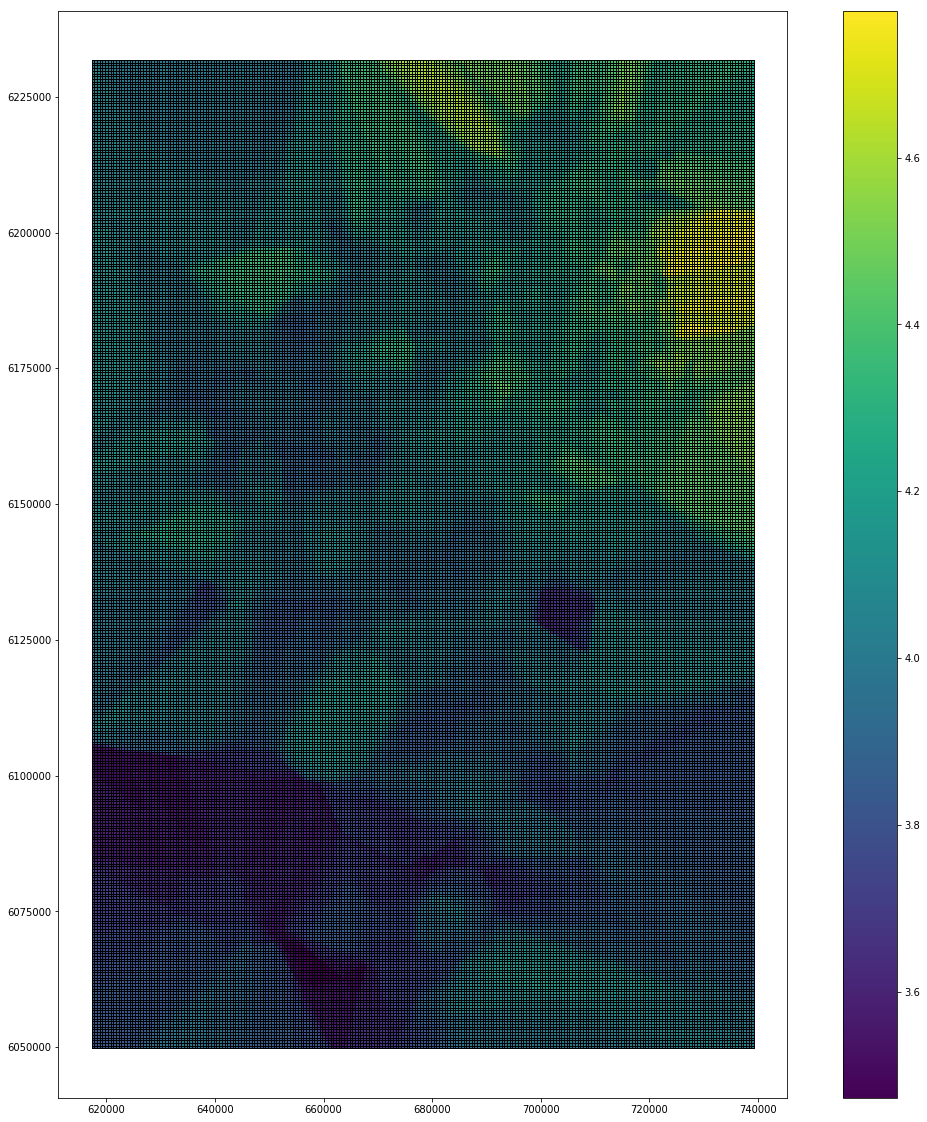

In [124]:
# plot the grid data for 2012
grid_plt = plt.subplots(1,1,figsize=(20,20))
squares_df.plot(color='lightgrey',edgecolor='black',ax=grid_plt[1])
squares_df.plot(edgecolor='black',column='s2013',legend=True,ax=grid_plt[1])
plt.show()

<br>
<br>
<br>
<br>

# Questions from exercise set 10 (Spatial #2)

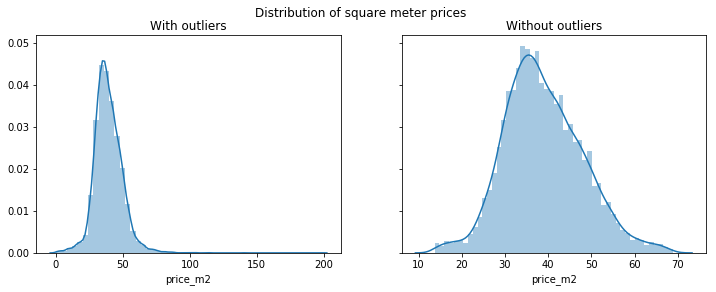

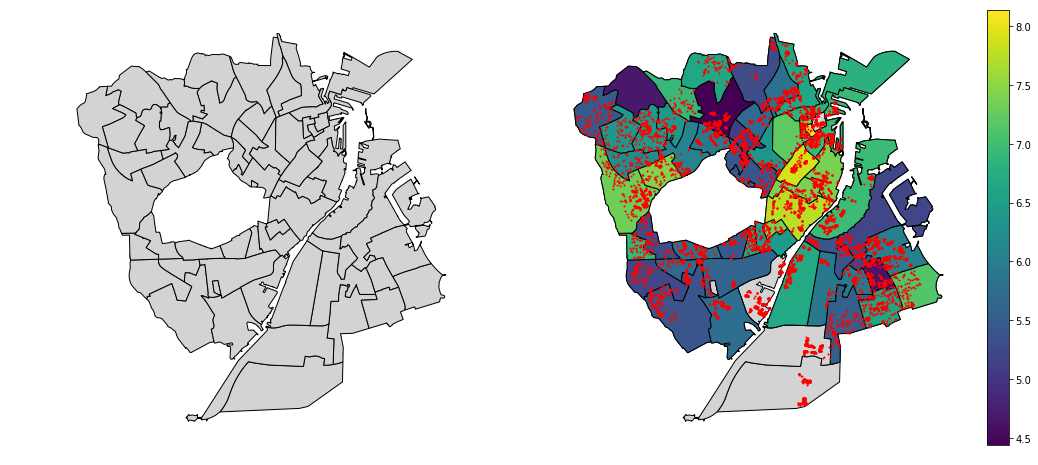

In [110]:
import shapely as shp
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# You need to download these files to get going. See the exercise set 
# for instructions.
districts = gpd.read_file('school_districts_2017_2018.geojson')
socioeco = gpd.read_file('socioeco_edited.geojson')
school_perf = pd.read_csv('school_perf.csv')
house_sales = gpd.read_file('sales.geojson')

cph_map = gpd.read_file('cph_map.geojson').iloc[0,0]

districts = districts[['skoleid','skolenavn','geometry']]
house_sales = house_sales[house_sales['year']>2016]

percs = house_sales['price_m2'].quantile([0.01,0.99])

sales_dist_plt = plt.subplots(1,2,sharey=True,figsize=(12,4))
sns.distplot(house_sales['price_m2'], ax=sales_dist_plt[1][0]) 
house_sales = house_sales[(percs[0.01]<house_sales['price_m2']) & (house_sales['price_m2']<percs[0.99])]
sns.distplot(house_sales['price_m2'], ax=sales_dist_plt[1][1])
sales_dist_plt[1][0].set_title('With outliers')
sales_dist_plt[1][1].set_title('Without outliers')
sales_dist_plt[0].suptitle('Distribution of square meter prices')
plt.show()

districts_perf = districts.merge(school_perf[school_perf['year']<2017].drop('year',axis=1).groupby('skolenavn',as_index=False).mean())

socioeco_sub = socioeco\
    .loc[socioeco['aar']==2016,['rode_nr','geometry']]\
    .merge(socioeco[socioeco['aar']>2012]\
               .groupby('rode_nr',as_index=False)\
               .mean()
          )\
    .drop('aar',axis=1)


districts_perf_plt = plt.subplots(1,2,figsize=(18,8), gridspec_kw = {'width_ratios':[1,1.25]})
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][0])
districts.plot(color='lightgrey',edgecolor='black',ax=districts_perf_plt[1][1])
districts_perf.plot(edgecolor='black',column='karsnit',legend=True,ax=districts_perf_plt[1][1])
house_sales.plot(color='red', markersize=1,ax=districts_perf_plt[1][1])
districts_perf_plt[1][0].set_axis_off()
districts_perf_plt[1][1].set_axis_off()
plt.show()

**Ex 10.1.1**: *Border regions between school districts*.
 Make a function that finds the borders between the school districts given some specified border-width W. Make sure that your border building function satisfy the following constraints:
 - The borders should not intersect each other. There should be no borders between the school districts without any grade data and any other school districts. 
 - Do not include borders between two school districts, if the district border coincides with a natural geographical border, such that the neighborhoods on each side of the geographical border are likely to be systematically different with regard to other variables than the school characteristics. For instance, it would be natural to exclude the Christianhavn school district from the analysis, since it is surrounded by the harbor and *Voldene*, and likewise it would be natural not to include the border between two school districts, if they are on different sides of the harbor. 

 Compute the borders for the following border meter widths: 50, 100, 200, 300, 500. A border width of, for instance, 50 meters means that the computed border area should reach 25 meter into each district along the actual border:

> **Hint**: One approach is to use a combination of the *buffer* and *overlay* function from *Geopandas* to construct the borders. Depending on your choice of method, the found borders will likely overlap, but you can then use *overlay* to find the overlap. After you have found the overlaps, you can use the *shapely* function *difference* to remove them. You can use a similar approach with the *cph_map* from above to remove borders between school districts on different sides of the harbor.

> **Hint 2**: The borders produced should look like this.

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/border_plt.png">


In [15]:
# [Answer to ex. 10.1.1 here]

schools = school_perf['skolenavn'].unique() # School districts with no grade data
no_perf_area = districts[~(districts['skolenavn'].isin(schools))]['geometry'].unary_union

def make_borders(districts, border_width) :
    
    ################
    # make borders #
    ################
    
    # put buffer 
    buffer_dist = border_width / 2
    districts['geometry'] = districts.buffer(buffer_dist)
    
    # make overlay
    borders = gpd.overlay(districts,districts,how='intersection')
    borders = borders[~(borders['geometry'].apply(lambda poly : poly.is_empty))]
    borders = borders[borders['skoleid_1']!=borders['skoleid_2']]
    
    # name borders
    borders['border_id'] = borders.apply(lambda row : sorted((row['skoleid_1'],row['skoleid_2'])),axis=1)
    borders['border_id'] = borders['border_id'].apply(lambda border : '{0}-{1}'.format(border[0],border[1]))
    borders = borders.drop_duplicates('border_id').reset_index(drop=True)
    
    #####################
    # remove irrelevant #
    #####################
    
    # conflicting border 
    conflict_b = gpd.overlay(borders[['border_id','geometry']],
                             borders[['border_id','geometry']],
                             how='intersection')
    non_empty = pd.Series(~(conflict_b['geometry'].apply(lambda poly : poly.is_empty)))
    has_conflict = conflict_b['border_id_1']!=conflict_b['border_id_2']      
    conflict_b_uu = conflict_b[non_empty & has_conflict].geometry.unary_union
        
    # join with water 
    removal = shp.geometry.box(*cph_map.bounds).difference(cph_map).buffer(buffer_dist)    
    removal = removal.union(conflict_b_uu).union(no_perf_area.buffer(buffer_dist))
    
    # apply removal 
    borders['geometry'] = borders['geometry'].apply(lambda border : border.difference(removal))
    borders = borders[~(borders['geometry'].apply(lambda poly : poly.is_empty))]
    
    return borders.reset_index(drop=True)

In [16]:
# Apply border function
border_widths = [50,100,150,200,300,500]
remove_chr_havn = districts_perf['skolenavn']!='Christianshavns Skole'
# removal, conflict_b_uu, no_perf_area, buffer_dist = make_borders(districts_perf[remove_chr_havn].copy(),50)
borders = [make_borders(districts_perf[remove_chr_havn].copy(),d) for d in border_widths]

In [17]:
borders[5].head(2)

,skoleid_1,skolenavn_1,karsnit_1,skoleid_2,skolenavn_2,karsnit_2,geometry,border_id
0,101020,Kirkebjerg Skole,6.26,101021,Korsager Skole,5.48,"POLYGON ((718064.4284816019 6178351.524552162,...",101020-101021
1,101023,Tingbjerg Skole,4.68,101021,Korsager Skole,5.48,(POLYGON ((718033.6201053072 6179698.460216083...,101021-101023


**Ex 10.1.2**: Do the following
  1. Merge the residential sales with the school districts and socioeconomic data based on the coordinates of the sale and the school districts and rode areas (CPH municapality's spatial cells). 
  2. Find the residential sales located within the sets of borders for the different border widths. 
  3. Plot the located within the border sets for the different border widths.

> **Hint**: Recall the `sjoin` function from `geopandas` may be of help.

The selected houses within borders should look like:

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/border_sales_plt.png">


In [18]:
borders[1].head(2)

,skoleid_1,skolenavn_1,karsnit_1,skoleid_2,skolenavn_2,karsnit_2,geometry,border_id
0,101023,Tingbjerg Skole,4.68,101021,Korsager Skole,5.48,"POLYGON ((718171.3770778859 6179995.970433375,...",101021-101023
1,101017,Husum Skole,6.42,101021,Korsager Skole,5.48,"POLYGON ((717762.7388672219 6178876.21878856, ...",101017-101021


In [19]:
# [Answer to ex. 10.1.2 here]
# merging data
house_sales_dp = gpd.sjoin(left_df=house_sales,
                          right_df=districts_perf, 
                          how='left',
                          op='within')\
                .drop('index_right', axis=1)
house_sales_char = gpd.sjoin(left_df=house_sales_dp,
                          right_df=socioeco_sub, 
                          how='left',
                          op='within')\
                .drop('index_right', axis=1)

# sales within borders
border_sales = [gpd.sjoin(left_df=house_sales_char,
                          right_df=bord[['border_id', 'geometry']], 
                          how='left',
                          op='within')\
                .drop('index_right', axis=1)
            for bord in borders]

In [20]:
border_sales[1].head(1)

,address,city,res_area,price_m2,sale_date,year,geometry,skoleid,skolenavn,karsnit,...,pct_kort_viderg_udd,pct_mellemlang_viderg_udd,pct_ingen_udd,pct_under_udd,pct_lav_indkomst,pct_middel_indkomst,pct_ikke_vestlig,pct_almen_bolig,alder_pct_30_64,border_id
19385,"Østerbrogade 84D, 3.",København Ø,293.0,36.860068,2017-01-01,2017,POINT (724806.9681905715 6178568.036372054),101039.0,Randersgades Skole,7.38,...,5.0,18.333333,15.0,20.0,26.666667,21.666667,5.0,0.0,50.0,101039-101157


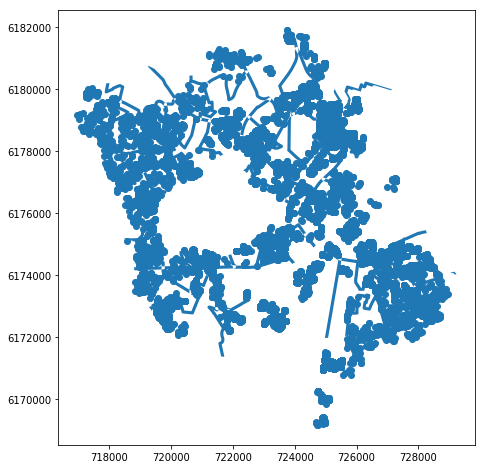

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
border_sales[1]["geometry"].plot(ax=ax)
borders[1]["geometry"].plot(ax=ax)
plt.show()

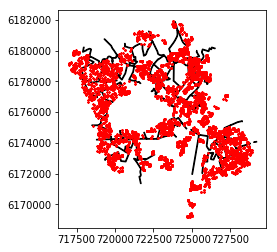

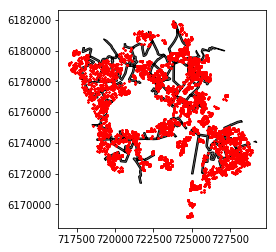

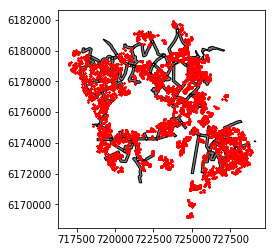

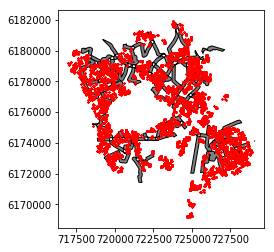

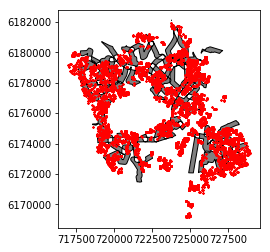

In [37]:
for bord in range(5):
    base = borders[bord].plot(color = 'grey', edgecolor = 'black')
    border_sales[bord].plot(ax = base, marker = 'x', color = "red", markersize = 3)

<br>

**Ex 10.1.3**:  Run a linear regression of the effect of schools' grade average on square meter prices, where you control for the size of the sold property and relevant socioeconomic properties of the neighborhood. We have used percent of non-western immigrants and descendants, low income, non-educated and high school educated as our socioeconomic variables, but you can play around with it.

In [38]:
lin_1 = stats.ols("price_m2 ~ karsnit + res_area + pct_ikke_vestlig + pct_lav_indkomst + pct_tilkn_arb_markedet", data = house_sales_char).fit()
lin_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_m2   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     382.6
Date:                Tue, 23 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:40:23   Log-Likelihood:                -33345.
No. Observations:                9425   AIC:                         6.670e+04
Df Residuals:                    9419   BIC:                         6.674e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 37.7957      2.973     12.715      0.000      31.969      43.623
karsnit                    2.1162      0.119     17.824      0.000       1.883       2.349
res_area                   0.0239      0.002     10.050      0.000       0.019       0.029
pct_ikke_vestlig          -0.4146      0.018    -22.426      0.000      -0.451      -0.378
pct_lav_indkomst           0.0901      0.013      6.904      0.000       0.064       0.116
pct_tilkn_arb_markedet    -0.1482      0.028     -5.237      0.000      -0.204      -0.093
==============================================================================
Omnibus:                       75.204   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.434
Skew:                          -0.016   Prob(JB):                     1.92e-26
Kurtosis:                       3.548   Cond. No.                     4.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<br>

**Ex 10.1.4**:  For each border width now try to run a linear regression of the effect of schools' average grade on square meter prices, where you only use the sales within the borders and control for residential area, socioeconomic neighborhood properties and border fixed effects.

In [39]:
border_sales[0].head(1)

,address,city,res_area,price_m2,sale_date,year,geometry,skoleid,skolenavn,karsnit,...,pct_kort_viderg_udd,pct_mellemlang_viderg_udd,pct_ingen_udd,pct_under_udd,pct_lav_indkomst,pct_middel_indkomst,pct_ikke_vestlig,pct_almen_bolig,alder_pct_30_64,border_id
19385,"Østerbrogade 84D, 3.",København Ø,293.0,36.860068,2017-01-01,2017,POINT (724806.9681905715 6178568.036372054),101039.0,Randersgades Skole,7.38,...,5.0,18.333333,15.0,20.0,26.666667,21.666667,5.0,0.0,50.0,101039-101157


In [40]:
model_0 = stats.ols("price_m2 ~ karsnit + res_area + pct_ikke_vestlig + pct_lav_indkomst + pct_tilkn_arb_markedet + C(border_id)", data = border_sales[0]).fit()
model_1 = stats.ols("price_m2 ~ karsnit + res_area + pct_ikke_vestlig + pct_lav_indkomst + pct_tilkn_arb_markedet + C(border_id)", data = border_sales[1]).fit()
model_2 = stats.ols("price_m2 ~ karsnit + res_area + pct_ikke_vestlig + pct_lav_indkomst + pct_tilkn_arb_markedet + C(border_id)", data = border_sales[2]).fit()
model_3 = stats.ols("price_m2 ~ karsnit + res_area + pct_ikke_vestlig + pct_lav_indkomst + pct_tilkn_arb_markedet + C(border_id)", data = border_sales[3]).fit()
model_4 = stats.ols("price_m2 ~ karsnit + res_area + pct_ikke_vestlig + pct_lav_indkomst + pct_tilkn_arb_markedet + C(border_id)", data = border_sales[4]).fit()



In [41]:
from statsmodels.iolib.summary2 import summary_col 
summary_table = summary_col([lin_1, model_0, model_1, model_2, model_3, model_4], 
                           stars = True,
                           regressor_order = ["karsnit", "res_area","pct_ikke_vestlig", "pct_lav_indkomst", "pct_tilkn_arb_markedet"],
                           model_names = ["Basic", "border_50","border_100","border_200","border_300","border_500"],
                           drop_omitted = True)

In [42]:
summary_table

,Basic,border_50,border_100,border_200,border_300,border_500
karsnit,2.1162***,1.4875**,1.2303**,1.0404**,0.8910**,-0.0997
,(0.1187),(0.6631),(0.4976),(0.4317),(0.3878),(0.3493)
res_area,0.0239***,-0.0363***,-0.0399***,-0.0288***,-0.0268***,-0.0095**
,(0.0024),(0.0067),(0.0053),(0.0044),(0.0041),(0.0037)
pct_ikke_vestlig,-0.4146***,-0.0579,-0.0502,-0.1058***,-0.0936***,-0.1858***
,(0.0185),(0.0645),(0.0470),(0.0390),(0.0349),(0.0318)
pct_lav_indkomst,0.0901***,-0.1161*,-0.1872***,-0.1352***,-0.1075***,-0.1429***
,(0.0130),(0.0638),(0.0454),(0.0371),(0.0334),(0.0325)
pct_tilkn_arb_markedet,-0.1482***,-0.0115,0.0269,-0.0044,0.0151,-0.1997***
,(0.0283),(0.1147),(0.0856),(0.0741),(0.0668),(0.0519)


<br>

**Ex 10.1.5**:  Compare the estimated effect from the controlled linear regression on all sales with the estimated effects from the linear regressions on the different border sets. The figure below show a summary of the results, we get from our analysis. The blue lines are confidence intervals of the effect of schools' average grade on house prices estimated with the different border sets (we do not use clustering). The grey area shows the confidence interval from the controlled linear regression model on all the sales.

<img src="https://github.com/abjer/tsds/raw/master/material/10_spatial2/results_fig.png">

 Would you say that the results suggest that there is a causal effect of the local shool's average grade on square meter price? Would you have expected that the estimated effect declines, when borders of greater width are used to estimate it? If not, what could explain that we this? Investigate your hypothesis, if you have time  for it (and tell us, if you find something interesting).


> ***Answer to ex. 10.1.5:***
>
> We see that estimates using border fixed effects are all below the confidence interval of the cross sectional analysis. This indicates that the cross-section analysis is biased. We see that for larger border sizes the effect vanishes. (The bonus question 10.1.6 dives into possible explanations).